In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from xgboost import  XGBClassifier

In [73]:
train = pd.read_csv('./data/train.csv')
train['label'] = 'train'
test = pd.read_csv('./data/test.csv')
test['label'] = 'test'
test_passengerId = test.PassengerId
df = train.append(test)
df.sample(4)

Age Cabin Embarked    Fare                                     Name  \
603  44.0   NaN        S   8.050                Torber, Mr. Ernst William   
850   4.0   NaN        S  31.275  Andersson, Master. Sigvard Harald Elias   
322  26.0    F2        S  13.000                       Nesson, Mr. Israel   
760   NaN   NaN        S  14.500                       Garfirth, Mr. John   

     Parch  PassengerId  Pclass   Sex  SibSp  Survived  Ticket  label  
603      0          604       3  male      0       0.0  364511  train  
850      2          851       3  male      4       0.0  347082  train  
322      0         1214       2  male      0       NaN  244368   test  
760      0          761       3  male      0       0.0  358585  train

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
label          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [75]:
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
label             0
dtype: int64

In [76]:
df.describe(include='all')

Age        Cabin Embarked         Fare              Name  \
count   1046.000000          295     1307  1308.000000              1309   
unique          NaN          186        3          NaN              1307   
top             NaN  C23 C25 C27        S          NaN  Kelly, Mr. James   
freq            NaN            6      914          NaN                 2   
mean      29.881138          NaN      NaN    33.295479               NaN   
std       14.413493          NaN      NaN    51.758668               NaN   
min        0.170000          NaN      NaN     0.000000               NaN   
25%       21.000000          NaN      NaN     7.895800               NaN   
50%       28.000000          NaN      NaN    14.454200               NaN   
75%       39.000000          NaN      NaN    31.275000               NaN   
max       80.000000          NaN      NaN   512.329200               NaN   

              Parch  PassengerId       Pclass   Sex        SibSp    Survived  \
count   1309.000000  1309.000000  1309.000000  1309  1309.000000  891.000000   
unique          NaN          NaN          NaN     2          NaN         NaN   
top             NaN          NaN          NaN  male          NaN         NaN   
freq            NaN          NaN          NaN   843          NaN         NaN   
mean       0.385027   655.000000     2.294882   NaN     0.498854    0.383838   
std        0.865560   378.020061     0.837836   NaN     1.041658    0.486592   
min        0.000000     1.000000     1.000000   NaN     0.000000    0.000000   
25%        0.000000   328.000000     2.000000   NaN     0.000000    0.000000   
50%        0.000000   655.000000     3.000000   NaN     0.000000    0.000000   
75%        0.000000   982.000000     3.000000   NaN     1.000000    1.000000   
max        9.000000  1309.000000     3.000000   NaN     8.000000    1.000000   

          Ticket  label  
count       1309   1309  
unique       929      2  
top     CA. 2343  train  
freq          11    891  
mean         NaN    NaN  
std          NaN    NaN  
min          NaN    NaN  
25%          NaN    NaN  
50%          NaN    NaN  
75%          NaN    NaN  
max          NaN    NaN

In [77]:
df['Embarked'].fillna('S',inplace=True)

In [78]:
df[df.Fare.isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
152  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

     Pclass   Sex  SibSp  Survived Ticket label  
152       3  male      0       NaN   3701  test

In [79]:
df.corr().Fare

Age            0.178740
Fare           1.000000
Parch          0.221539
PassengerId    0.031428
Pclass        -0.558629
SibSp          0.160238
Survived       0.257307
Name: Fare, dtype: float64

In [80]:
print(df[df.Pclass==1].Fare.quantile([0.25,0.50,0.75]))
print(df[df.Pclass==2].Fare.quantile([0.25,0.50,0.75]))
print(df[df.Pclass==3].Fare.quantile([0.25,0.50,0.75]))

0.25     30.6958
0.50     60.0000
0.75    107.6625
Name: Fare, dtype: float64
0.25    13.0000
0.50    15.0458
0.75    26.0000
Name: Fare, dtype: float64
0.25     7.7500
0.50     8.0500
0.75    15.2458
Name: Fare, dtype: float64


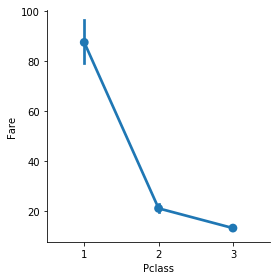

In [81]:
sns.factorplot(x='Pclass',y='Fare',data=df)

In [82]:
df['Fare'].fillna(df[df.Pclass == 3].Fare.median(), inplace = True)

In [83]:
print("Age column has", df.Age.isnull().sum(), "missing values out of", len(df), ". Missing value percentage =", df.Age.isnull().sum()/len(df)*100)

Age column has 263 missing values out of 1309 . Missing value percentage = 20.091673032849503


In [84]:
df.corr().Age

Age            1.000000
Fare           0.177286
Parch         -0.150917
PassengerId    0.028814
Pclass        -0.408106
SibSp         -0.243699
Survived      -0.077221
Name: Age, dtype: float64

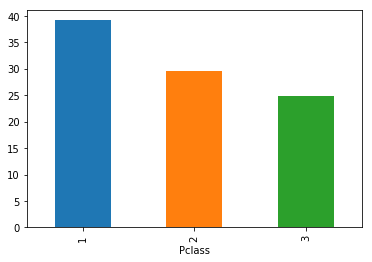

In [85]:
df.pivot_table(values = 'Age',index = 'Pclass').Age.plot.bar()

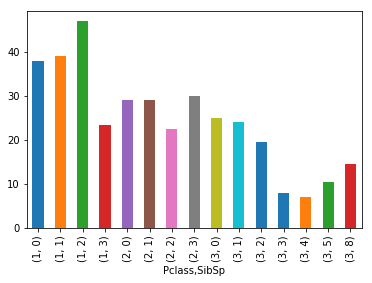

In [86]:
df.pivot_table(values='Age',index=['Pclass','SibSp'],aggfunc='median').Age.plot.bar()

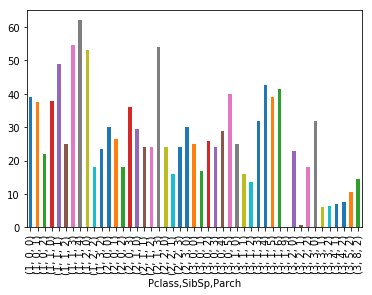

In [87]:
df.pivot_table(values='Age',index=['Pclass','SibSp','Parch'],aggfunc='median').Age.plot.bar()

In [88]:
df.Age.isnull().sum()

263

In [89]:
age_null = df.Age.isnull()
group_med_age = df.pivot_table(values='Age',index=['Pclass','SibSp'],aggfunc='median')
df.loc[age_null,'Age'] = df.loc[age_null,['Pclass','SibSp']].apply(lambda x:group_med_age.loc[(group_med_age.index.get_level_values('Pclass')==x.Pclass)&(group_med_age.index.get_level_values('SibSp')==x.SibSp)].Age.values[0],axis=1)

In [90]:
df.Age.isnull().sum()

0

In [91]:
print("Cabin has",df.Cabin.isnull().sum(),"missing values out of",len(df))

Cabin has 1014 missing values out of 1309


In [92]:
df['Cabin'] = df.Cabin.str[0]
df.Cabin.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [93]:
df.Cabin.fillna('0',inplace=True)

In [94]:
df.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
label            0
dtype: int64

In [95]:
df.sample(2)

Age Cabin Embarked      Fare                            Name  Parch  \
449  52.0     C        S   30.5000  Peuchen, Major. Arthur Godfrey      0   
252  27.0     C        C  136.7792        Clark, Mr. Walter Miller      0   

     PassengerId  Pclass   Sex  SibSp  Survived  Ticket  label  
449          450       1  male      0       1.0  113786  train  
252         1144       1  male      1       NaN   13508   test

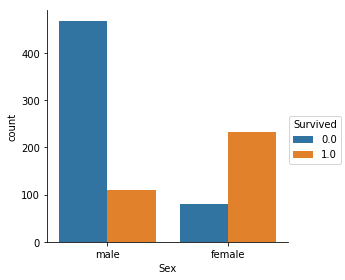

In [96]:
sns.factorplot(data=df,x='Sex',hue='Survived',kind='count')

Text(0,0.5,'Survived Probability')

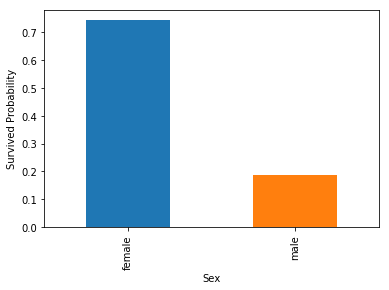

In [97]:
df.pivot_table(values='Survived',index='Sex').Survived.plot.bar()
plt.ylabel('Survived Probability')

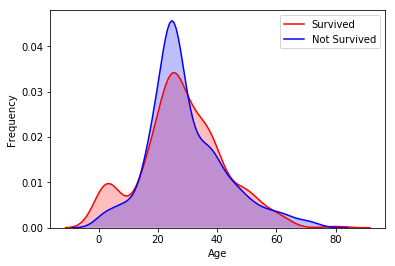

In [98]:
q = sns.kdeplot(df.Age[df.Survived==1],shade=True,color='red')
q = sns.kdeplot(df.Age[df.Survived==0],shade=True,color='blue')
q.set_xlabel('Age')
q.set_ylabel('Frequency')
q = q.legend(['Survived','Not Survived'])

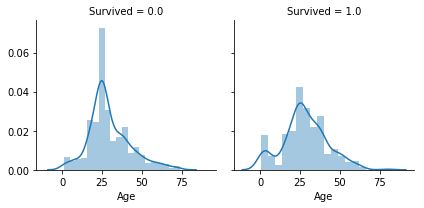

In [99]:
q = sns.FacetGrid(df,col='Survived')
q.map(sns.distplot,'Age')

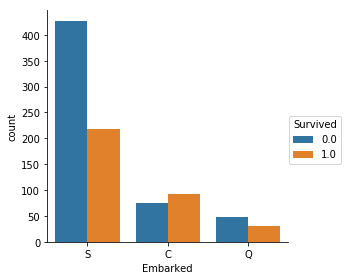

In [100]:
sns.factorplot(data=df,x='Embarked',hue='Survived',kind='count')

Text(0,0.5,'Survived Probability')

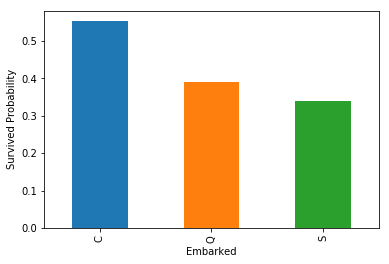

In [101]:
df.pivot_table(values='Survived',index='Embarked').Survived.plot.bar()
plt.ylabel('Survived Probability')

Text(0,0.5,'Survived Probability')

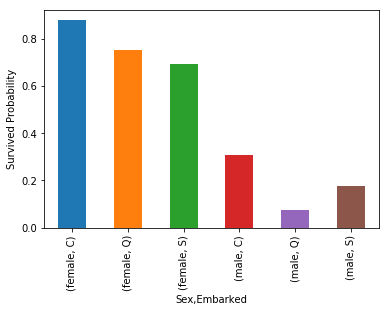

In [102]:
df.pivot_table(values='Survived',index=['Sex','Embarked']).Survived.plot.bar()
plt.ylabel('Survived Probability')

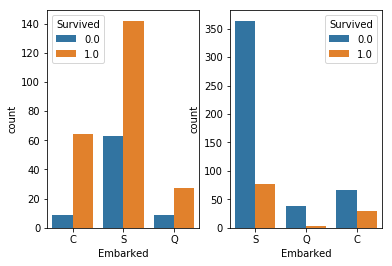

In [103]:
fig,ax = plt.subplots(1,2)
sns.countplot(data = df[df.Sex == 'female'],x = 'Embarked',hue = 'Survived',ax = ax[0])
sns.countplot(data = df[df.Sex == 'male'],x = 'Embarked',hue = 'Survived',ax = ax[1])
fig.show()

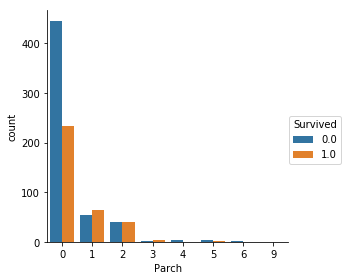

In [104]:
sns.factorplot(data=df,x='Parch',hue='Survived',kind = 'count')

In [105]:
df['Family_size'] = 1 + df.Parch + df.SibSp
df['Alone'] = np.where(df.Family_size == 1,1,0)

In [106]:
print(df.Family_size.value_counts())
print(df.Alone.value_counts())

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64
1    790
0    519
Name: Alone, dtype: int64


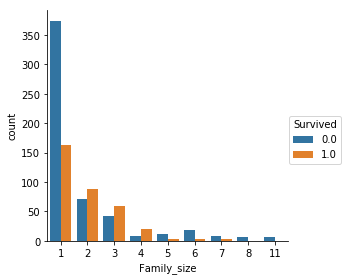

In [107]:
sns.factorplot(data=df,x = 'Family_size',hue = 'Survived',kind='count')

In [108]:
df.loc[df['Family_size'] == 1, 'Family_size_bin'] = 0
df.loc[(df['Family_size'] >= 2) & (df['Family_size'] <= 4), 'Family_size_bin'] = 1
df.loc[df['Family_size'] >=5, 'Family_size_bin'] = 2

In [109]:
df['title'] = df.Name.str.split(', ',expand=True)[1].str.split(".",expand = True)[0]
df.title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Don               1
Capt              1
Lady              1
Sir               1
Jonkheer          1
Mme               1
the Countess      1
Dona              1
Name: title, dtype: int64

In [110]:
minor_titles = df.title.value_counts()<=4
df['title'] = df.title.apply(lambda x: 'Others' if minor_titles.loc[x] == True else x)
df.title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Others     18
Dr          8
Rev         8
Name: title, dtype: int64

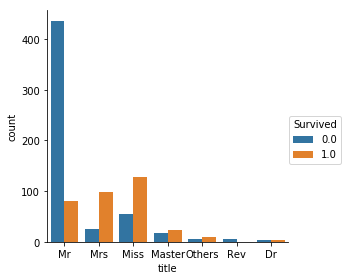

In [111]:
sns.factorplot(data=df,x='title',hue='Survived',kind='count')

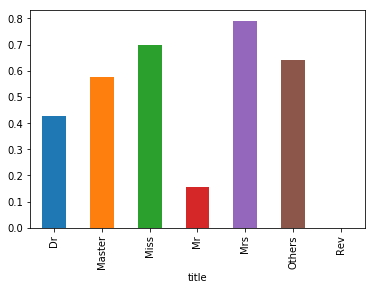

In [112]:
df.pivot_table(values='Survived',index='title').Survived.plot.bar()
plt.show()

In [113]:
df['Fare_bin'] = pd.qcut(df.Fare,4,labels=[0,1,2,3]).astype(int)
df['Age_bin'] = pd.cut(df.Age.astype(int),5,labels=[0,1,2,3,4]).astype(int)

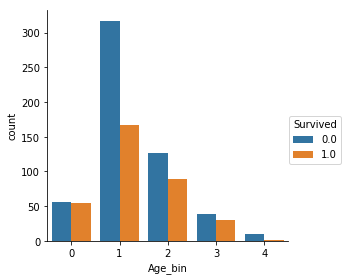

In [114]:
sns.factorplot(data=df,x = 'Age_bin',hue = 'Survived',kind='count')

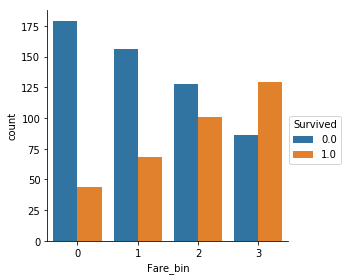

In [115]:
sns.factorplot(data=df,x = 'Fare_bin',hue = 'Survived',kind='count')

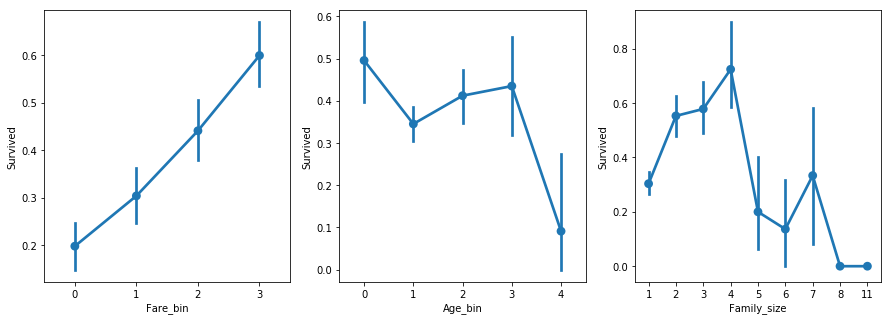

In [116]:
fig ,axs = plt.subplots(1,3,figsize = (15,5))
sns.pointplot(x = 'Fare_bin',y='Survived',data=df,ax = axs[0])
sns.pointplot(x = 'Age_bin',y='Survived',data=df,ax = axs[1])
sns.pointplot(x = 'Family_size',y='Survived',data=df,ax = axs[2])

In [117]:
label = LabelEncoder()
df['title'] = label.fit_transform(df.title)
df['Sex'] = label.fit_transform(df.Sex)
df['Embarked'] = label.fit_transform(df.Embarked)
df['Cabin'] = label.fit_transform(df.Cabin)

In [118]:
df.sample(2)

Age  Cabin  Embarked    Fare                     Name  Parch  \
795  39.0      0         2  13.000       Otter, Mr. Richard      0   
19   25.0      0         0   7.225  Masselmani, Mrs. Fatima      0   

     PassengerId  Pclass  Sex  SibSp  Survived Ticket  label  Family_size  \
795          796       2    1      0       0.0  28213  train            1   
19            20       3    0      0       1.0   2649  train            1   

     Alone  Family_size_bin  title  Fare_bin  Age_bin  
795      1              0.0      3         1        2  
19       1              0.0      4         0        1

In [119]:
corr_columns = list(df.drop(['Name', 'PassengerId', 'Ticket', 'label'], axis = 1).columns)

In [120]:
df['Ticket'] = df.Ticket.map(lambda x: re.sub(r'\W+','',x))

In [121]:
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit():
        Ticket.append(i[:2])
    else:
        Ticket.append('X')
df['Ticket'] = Ticket

In [122]:
df['Ticket'].unique()

array(['A5', 'PC', 'ST', 'X', 'PP', 'CA', 'SC', 'A4', 'SP', 'SO', 'WC',
       'WE', 'C1', 'Fa', 'LI', 'FC', 'SW', 'C7', 'AS', 'C4', 'AQ', 'A2',
       'LP'], dtype=object)

In [123]:
df = pd.get_dummies(df,columns=['Ticket'],prefix='T')

In [124]:
cat_variables = [x for x in df.columns if df.dtypes[x] == 'object']
cat_variables

['Name', 'label']

In [125]:
df.drop(['Name','PassengerId'],axis = 1,inplace=True)

In [126]:
df.sample(2)

Age  Cabin  Embarked  Fare  Parch  Pclass  Sex  SibSp  Survived  label  \
431  24.0      0         2  16.1      0       3    0      1       1.0  train   
834  18.0      0         2   8.3      0       3    1      0       0.0  train   

    ...   T_PC  T_PP  T_SC  T_SO  T_SP  T_ST  T_SW  T_WC  T_WE  T_X  
431 ...      0     0     0     0     0     0     0     0     0    1  
834 ...      0     0     0     0     0     0     0     0     0    1  

[2 rows x 39 columns]

In [127]:
train = df.loc[df.label == 'train'].drop('label',axis = 1)
test = df.loc[df.label == 'test'].drop(['label','Survived'],axis = 1)

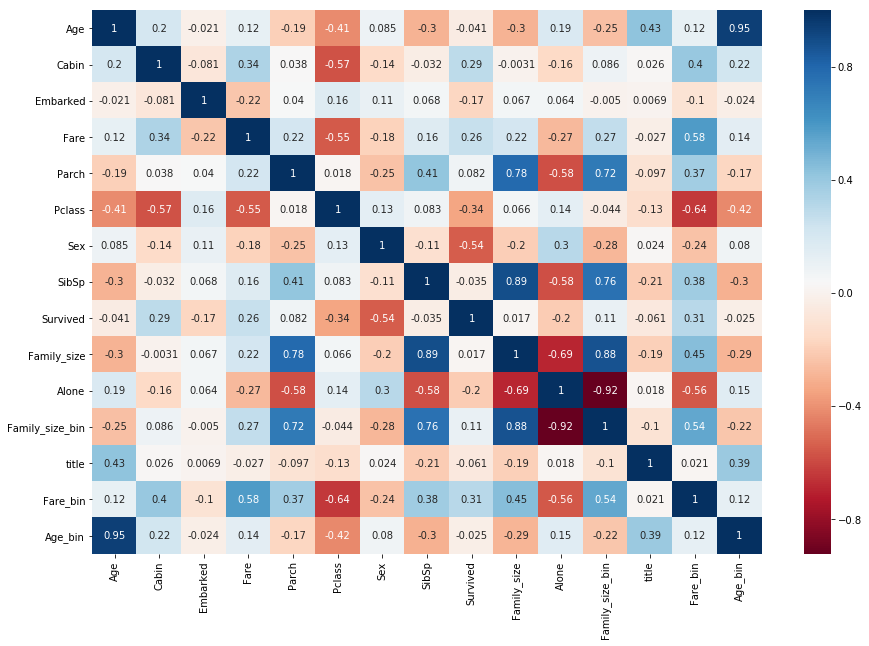

In [131]:
plt.figure(figsize = [15,10])
sns.heatmap(train[corr_columns].corr(),cmap='RdBu',annot=True)

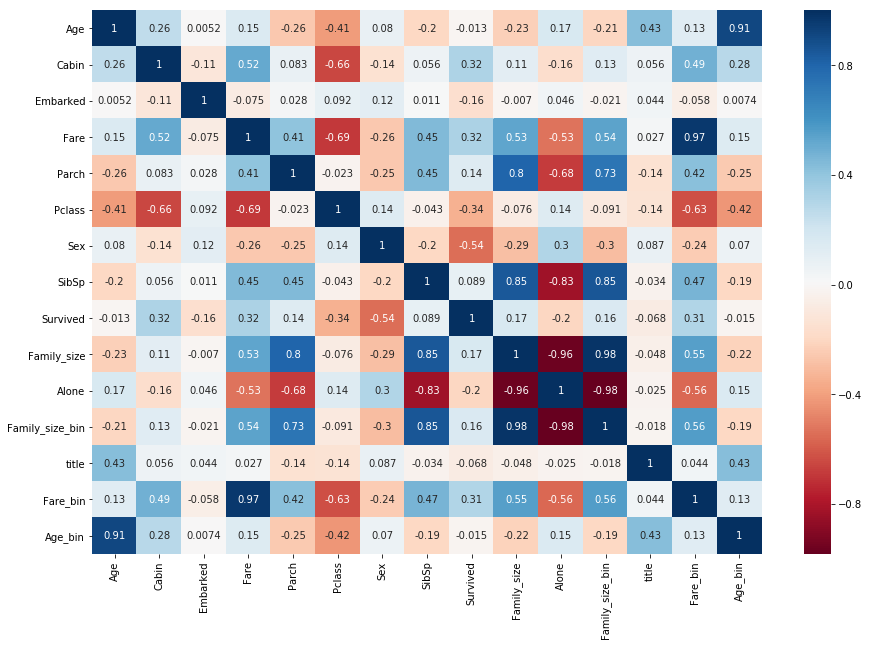

In [133]:
plt.figure(figsize = [15,10])
sns.heatmap(train[corr_columns].corr(method = 'spearman'),cmap='RdBu',annot=True)

In [135]:
x_train = train.drop(['Survived'],axis=1)
y_train = train['Survived'].astype(int)
x_test = test

In [136]:
x_train1,x_val,y_train1,y_val = train_test_split(x_train,y_train,test_size=0.30,random_state=2)

In [137]:
xgb = XGBClassifier(random_state=0).fit(x_train1,y_train1)
y_pred = xgb.predict(x_val)
print('Training accuracy',xgb.score(x_train1,y_train1))
print('Evaluation accuracy',xgb.score(x_val,y_val))

Training accuracy 0.8876404494382022
Evaluation accuracy 0.8022388059701493


In [138]:
cross_val_score(xgb,x_train,y_train,cv=5).mean()

0.8272155308184626

In [139]:
param_grid = {'max_depth' : [3,4,5,6], 'n_estimators' : [100,200,300], 'learning_rate' : [0.001,0.01,0.1,0.5],
              'booster' : ['gbtree', 'dart', 'gblinear']}
grid_search = GridSearchCV(XGBClassifier(random_state = 0), param_grid, scoring = 'roc_auc', cv = 3, n_jobs = -1)

In [140]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1, 0.5], 'booster': ['gbtree', 'dart', 'gblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [141]:
grid_search.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 100}

In [143]:
xgb = XGBClassifier(max_depth = 6, learning_rate = 0.01, random_state = 0).fit(x_train, y_train)

In [144]:
y_pred = xgb.predict(x_test)
print("Training accuracy = ",xgb.score(x_train,y_train))

Training accuracy =  0.8765432098765432


In [146]:
feature_imp = xgb.feature_importances_
feature_imp

array([0.28467712, 0.08100879, 0.02216278, 0.2800917 , 0.00955292,
       0.06572411, 0.03821169, 0.06457776, 0.05769965, 0.        ,
       0.        , 0.04356133, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03744746, 0.        , 0.        ,
       0.        , 0.01528468], dtype=float32)

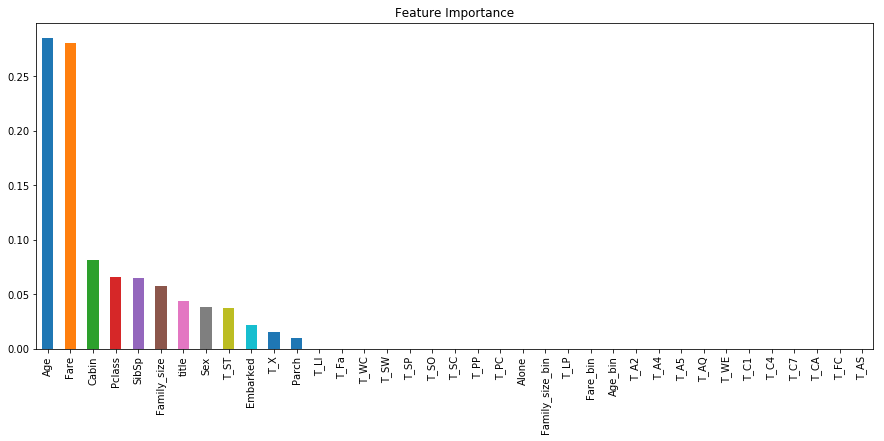

In [148]:
feature = pd.Series(feature_imp, x_train.columns).sort_values(ascending = False)
plt.figure(figsize = (15,6))
feature.plot(kind = 'bar', title = 'Feature Importance')

In [150]:
XGB = pd.DataFrame(test_passengerId, columns = ['PassengerId']).assign(Survived = pd.Series(y_pred))
XGB.to_csv('./data/XGB.csv', index = None)

In [151]:
y_pred1 = xgb.predict(x_val)
y_pred1

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0])

In [155]:
y_val1 = np.array(y_val)

In [157]:
print(abs(y_pred1-y_val1).sum()/len(y_val1))

0.13432835820895522
